In [1]:
import matplotlib
matplotlib.use('Agg')
from collections import defaultdict
import pickle, time, re, nltk
import plotly 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.plotly as py
py.sign_in('hclent', 'eeg49e9880')
init_notebook_mode(connected=True)
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [2]:
data_samples = pickle.load(open("/Users/hclent/Desktop/data_samples_18952863+18269575.pickle", "rb")) #pre-processed already
nes_list = pickle.load(open("/Users/hclent/Desktop/nes_18952863+18269575.pickle", "rb"))
category_list = ['BioProcess', 'CellLine', 'Cellular_component', 'Family', 'Gene_or_gene_product', 'Organ', 'Simple_chemical', 'Site', 'Species', 'TissueType']

In [3]:
def frequency_dict(nes_list, category_list):
    #nes_stopwords = ['gene', 'genes', 'genetics', 'genome', 'genomic', 'chromosome', 'chromosomes', 'result', 'line', 'time']
    nesDict = defaultdict(lambda:0)
    for docs in nes_list:
        for key in docs:
            for category in category_list: #no error with category 'Potato'
                if key == category:
                    nes = (docs[key])
                    for n in nes:
                        nesDict[n] += 1
                    #     if n not in nes_stopwords:
                    #        nesDict[n] += 1
    return nesDict

nesDict = frequency_dict(nes_list, category_list)
#'vvap15': 1, 'porr': 1, 'c3g': 4, 'myc3': 1, 'atspl1-12': 1, 'cpnac id': 1

In [4]:
#makes the data for plotly heatmap
def doHeatmap(nesDict, n, data_samples):
    y = [] # y list of words
    x = [] # x list of documents
    z = [] # z list of lists with word counts for each document

    lemma_Dict = defaultdict(lambda:0)


    #remove plurals (very rough)
    for word in nesDict:
        p1 = re.compile('[a-z]{2,}[b-df-hj-np-tv-z]{1,}(es$|s$)')
        match1 = p1.search(word)
        if not match1:
            lemma_Dict[word] += nesDict[word]


    for word in lemma_Dict:
        # print(word)
        split_word = word.split(" ")
        # print(split_word)
        # print(type(split_word))
        len_word = len(split_word)
        # print(len_word)
        if int(lemma_Dict[word]) > int(n):
            y.append(word)
            #i = 0
            #print(word)
            word_counts = []
            for documents in data_samples:
                #docname = "doc"+str(i)
                #print(docname)
                unigrams_list = documents.split(" ")
                runningDict = defaultdict(lambda:0)

                if len_word == 1:
                    for unigram in unigrams_list:
                        if unigram == word:
                            #print(str(unigram)+" is the same as "+str(word))
                            runningDict[word] += 1
                        if unigram != word:
                            runningDict[word] += 0
                #bigrams
                if len_word == 2:
                    b = 2
                    bigrams = [ unigrams_list[i:i+b] for i in range(len(unigrams_list)-b)]
                    for grams in bigrams:
                        q = ' '
                        grams = str(q.join(grams))
                        if grams == word:
                            runningDict[word] +=1
                            #print(grams+' = '+word)
                        if grams != word:
                            runningDict[word] +=0

                #trigrams are too long for this data visualization

                #3 grams, 4 grams, +
                if len_word > 2:
                    #print("the named entity is too long")
                    pass
                #print(runningDict)
                word_counts.append(runningDict[word])
                #i +=1
            #print(word_counts)
            z.append(word_counts)

    i = 1
    for documents in data_samples:
        docname = "doc"+str(i)
        x.append(docname)
        i += 1
    return x, y, z

In [5]:
x, y, z = doHeatmap(nesDict, 170, data_samples)
print(y)
print(len(y))

['soybean', 'time', 'barley', 'biosynthesis', 'transcription', 'human', 'a. thaliana', 'branch', 'tomato', 'maize', 'rice', 'acid', 'case', 'linolenic acid', 's1', 'line', 'leaf', 'chromosome', 'arabidopsis thaliana', 'rapa', 'sorghum', 'seed', 'step', 'result', 'crop']
25


In [6]:
import numpy as np
nesCountX = np.array(z) #array of nes counts
print(nesCountX.shape)

(25, 165)


In [7]:
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import sys, pickle, math, random, numpy, time

def do_kemeans(sparse_matrix, k_clusters):
    t0 = time.time()
    print("* Beginning k-means clustering ... ")
    num_clusters = int(k_clusters)
    km = KMeans(init='k-means++', n_clusters=num_clusters)
    km.fit(sparse_matrix)
    clusters = km.labels_.tolist()
    print("done in %0.3fs." % (time.time() - t0))
    return clusters

clusters = do_kemeans(nesCountX, 6)
print(list(zip(clusters, y)))

* Beginning k-means clustering ... 
done in 0.025s.
[(0, 'soybean'), (2, 'time'), (2, 'barley'), (2, 'biosynthesis'), (2, 'transcription'), (2, 'human'), (1, 'a. thaliana'), (5, 'branch'), (2, 'tomato'), (3, 'maize'), (2, 'rice'), (0, 'acid'), (2, 'case'), (0, 'linolenic acid'), (2, 's1'), (2, 'line'), (2, 'leaf'), (4, 'chromosome'), (2, 'arabidopsis thaliana'), (1, 'rapa'), (3, 'sorghum'), (2, 'seed'), (2, 'step'), (2, 'result'), (2, 'crop')]


In [8]:
def sort_y(clusters, y):
    pairs = list(zip(clusters, y))
    #print(pairs)
    list0 = []
    list1 = []
    list2 = []
    list3 = []
    list4 = []
    list5 = []
    
    for p in pairs:
        if p[0] == 0:
            list0.append(p[1])
        if p[0] == 1:
            list1.append(p[1])
        if p[0] == 2:
            list2.append(p[1])
        if p[0] == 3:
            list3.append(p[1])
        if p[0] == 4:
            list4.append(p[1])
        if p[0] == 5:
            list4.append(p[1])
    new_order = list0 + list1 + list2 + list3 + list4 + list5
    #print(list0)
    #print("-------------------------------")
    #print(new_order)
    return new_order
        
    
new_order = sort_y(clusters, y)
print(new_order)

['soybean', 'acid', 'linolenic acid', 'a. thaliana', 'rapa', 'time', 'barley', 'biosynthesis', 'transcription', 'human', 'tomato', 'rice', 'case', 's1', 'line', 'leaf', 'arabidopsis thaliana', 'seed', 'step', 'result', 'crop', 'maize', 'sorghum', 'branch', 'chromosome']


In [9]:
#for handling a clustered y-axis
def doHeatmap3(nesDict, n, data_samples, new_order, old_x):
    x = []
    y = []
    z = []

    lemma_Dict = defaultdict(lambda:0)
    for word in nesDict:
        p1 = re.compile('[a-z]{2,}[b-df-hj-np-tv-z]{1,}(es$|s$)')
        match1 = p1.search(word)
        if not match1:
            lemma_Dict[word] += nesDict[word]         
    print("* made lemmas dict ...")
    
    for word in new_order:
        
    #for word in lemma_Dict:
        split_word = word.split(" ")
        len_word = len(split_word)
        if int(lemma_Dict[word]) > int(n): 
            y.append(word)
            word_counts = []     
            for j in range(0, len(data_samples)): #go in order. nes are clustered, not docs
                documents = data_samples[int(j)]
                unigrams_list = documents.split(" ")
                runningDict = defaultdict(lambda:0)
                if len_word == 1:
                    for unigram in unigrams_list:
                        if unigram == word:
                            runningDict[word] += 1
                        if unigram != word:
                            runningDict[word] += 0
                if len_word == 2:
                    b = 2
                    bigrams = [ unigrams_list[i:i+b] for i in range(len(unigrams_list)-b)]
                    for grams in bigrams:
                        q = ' '
                        grams = str(q.join(grams))
                        if grams == word:
                            runningDict[word] +=1
                            #print(grams+' = '+word)
                        if grams != word:
                            runningDict[word] +=0
                if len_word > 2:
                    pass
                word_counts.append(runningDict[word])
            z.append(word_counts)

    for i in range(1, len(old_x)+1):
        docname = "doc"+str(i)
        x.append(docname) 
    print("* done with stuff ...")
    return x, y, z
          
x1, y1, z1 = doHeatmap3(nesDict, 150, data_samples, new_order, x)
#print(x1)
print("Y-AXIS: ")
print(y1)
#print(z1)

* made lemmas dict ...
* done with stuff ...
Y-AXIS: 
['soybean', 'acid', 'linolenic acid', 'a. thaliana', 'rapa', 'time', 'barley', 'biosynthesis', 'transcription', 'human', 'tomato', 'rice', 'case', 's1', 'line', 'leaf', 'arabidopsis thaliana', 'seed', 'step', 'result', 'crop', 'maize', 'sorghum', 'branch', 'chromosome']


In [10]:
data = [
    go.Heatmap(
        z=z1,
        x=x1,
        y=y1,
        colorscale = [[0.0, 'rgb(204,204,204)'], [0.01111111111111111, 'rgb(69,79,220)'],[0.1111111111111111, 'rgb(84,73,210)'], [0.2222222222222222, 'rgb(98,67,201)'], [0.3333333333333333, 'rgb(127,54,181)'], [0.4444444444444444, 'rgb(142,48,172)'], [0.5555555555555556, 'rgb(171,36,152)'], [0.6666666666666666, 'rgb(199,24,133)'], [0.7777777777777778, 'rgb(214,17,123)'], [0.8888888888888888, 'rgb(228,11,114)'], [1.0, 'rgb(243,5,104)']]
    )
]
layout = go.Layout(
    title='K-means Clustered Heatmap, N=150, k=6; Clustered on doc y-axis')

fig1 = go.Figure(data=data, layout=layout)

py.iplot(fig1, filename='labelled-heatmap')

In [11]:
'''Lets try scipy"s kmeans'''
from scipy.cluster.vq import vq, kmeans, kmeans2, whiten
whitened = whiten(nesCountX) #whitened is a a weird data pre-processing thing scipy makes you use
kmeansSP = kmeans2(whitened, 5, iter=10, thresh=1e-05, minit='random', missing='warn')
print(len(kmeansSP[1]))
print(kmeansSP[1])


25
[2 4 2 2 3 2 0 4 2 3 2 0 0 2 2 0 2 0 0 3 4 4 4 3 2]


/Users/hclent/anaconda3/envs/pyNLP/lib/python3.4/site-packages/scipy/cluster/vq.py:148: RuntimeWarning:

Some columns have standard deviation zero. The values of these columns will not change.

/Users/hclent/anaconda3/envs/pyNLP/lib/python3.4/site-packages/scipy/cluster/vq.py:653: UserWarning:

One of the clusters is empty. Re-run kmean with a different initialization.



In [12]:
clustersSP = kmeansSP[1].tolist()
orderSP = sort_y(clustersSP, y)
print(orderSP)

['a. thaliana', 'acid', 'case', 'line', 'chromosome', 'arabidopsis thaliana', 'soybean', 'barley', 'biosynthesis', 'human', 'tomato', 'rice', 'linolenic acid', 's1', 'leaf', 'crop', 'transcription', 'maize', 'rapa', 'result', 'time', 'branch', 'sorghum', 'seed', 'step']


In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
''''ward' is one of the methods that can be used to calculate the distance between newly formed clusters. 
'ward' causes linkage() to use the Ward variance minimization algorithm.'''
Z_linkArray = linkage(nesCountX, 'average')

In [14]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z_linkArray, pdist(nesCountX))
print(c) #The closer the value is to 1, the better the clustering preserves the original distances

0.920749590766


In [15]:
'''linkage algorithm merged two clusteres with indivies 11 and 19
although their distance was 59. Created a cluster with 2 samples'''
Z_linkArray[0] #format [idx1, idx2, dist, sample_count].

array([ 12.     ,  14.     ,  59.92495,   2.     ])

In [16]:
Z_linkArray[:5]

array([[ 12.     ,  14.     ,  59.92495,   2.     ],
       [  4.     ,  25.     ,  64.36002,   3.     ],
       [ 21.     ,  24.     ,  70.54786,   2.     ],
       [ 22.     ,  26.     ,  71.76029,   4.     ],
       [ 27.     ,  28.     ,  72.7316 ,   6.     ]])

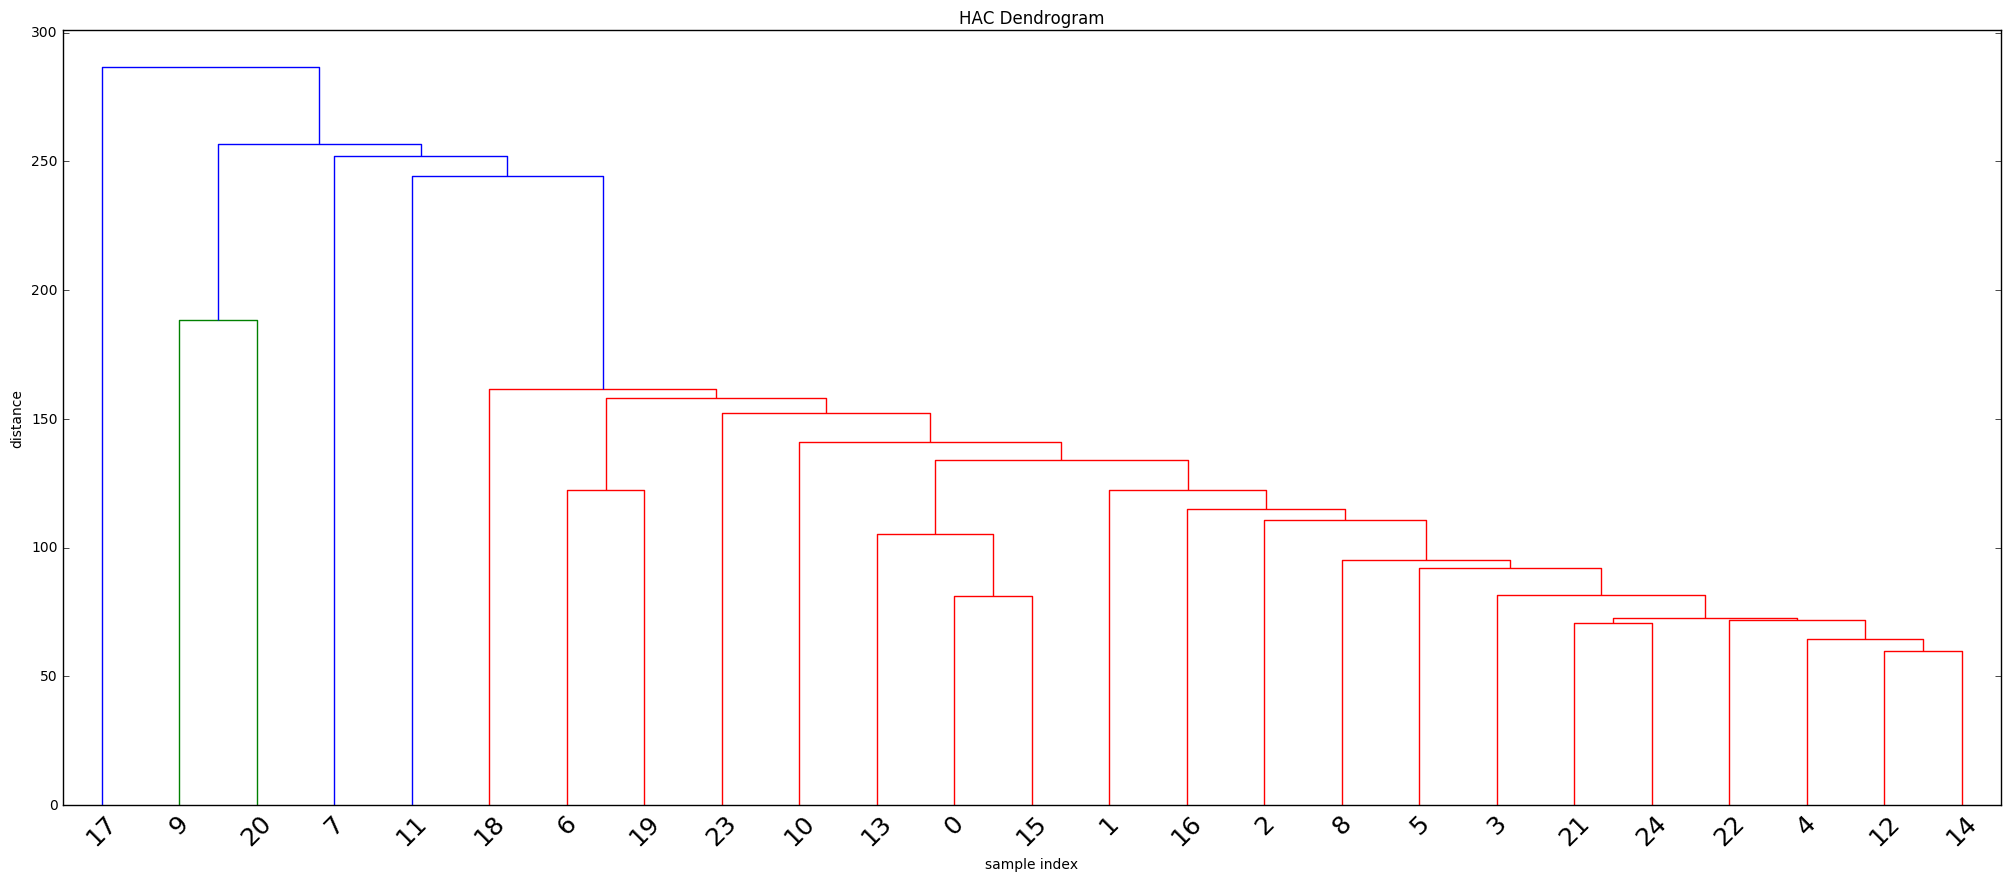

In [17]:
plt.figure(figsize=(25, 10))
plt.title('HAC Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z_linkArray,
    #leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18.,  # font size for the x axis labels
)
plt.show()

In [18]:
xLeaves = [y[12], y[0], y[14], y[18], y[11], y[13], y[1], y[17], y[6], y[7], y[4], y[3], y[21], y[20], y[10], y[2], y[15], y[16], y[8], y[19], y[22], y[24], y[5], y[9], y[23]]
print(xLeaves)

['case', 'soybean', 's1', 'arabidopsis thaliana', 'acid', 'linolenic acid', 'time', 'chromosome', 'a. thaliana', 'branch', 'transcription', 'biosynthesis', 'seed', 'sorghum', 'rice', 'barley', 'line', 'leaf', 'tomato', 'rapa', 'step', 'crop', 'human', 'maize', 'result']


In [19]:
from scipy.cluster.hierarchy import inconsistent
depth = 3
incons = inconsistent(Z_linkArray, depth)
# the inconsistency values heavily depend on the depth of the tree you calculate the averages over
print(incons[-10:])

[[ 111.53851   19.92557    5.         1.12908]
 [ 125.69387   15.65869    4.         0.98717]
 [ 142.47482    9.17211    3.         1.06429]
 [ 143.37728   15.71676    4.         0.92323]
 [ 148.44626   17.88046    4.         0.72601]
 [ 188.50729    0.         1.         0.     ]
 [ 187.86149   48.8828     3.         1.15394]
 [ 219.30539   50.281      3.         0.6546 ]
 [ 235.39134   31.66819    4.         0.66875]
 [ 245.98009   41.25591    4.         0.98518]]


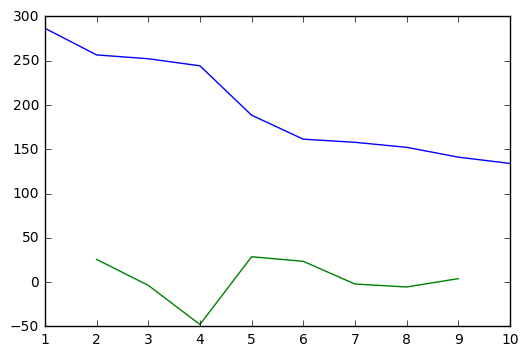

clusters: 5


'the "strongest elbow" of the blue line graph below, which is the highest value of the green graph below'

In [20]:
'''Elbow method'''

last = Z_linkArray[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters: "+ str(k))
'''the "strongest elbow" of the blue line graph below, which is the highest value of the green graph below'''

In [21]:
import seaborn as sns
import pandas as pd

In [22]:
def make_seaborn_data(x,y,z):
    seaData = []
    
    d = 0
    for document in x:
        i = 0
        for word in y:
            #print(i)
            count = z[i][d] #z[i] = word, z[i][j] = count of word for document
            data = (document, word, count)
            seaData.append(data)

            i += 1    
        d += 1
    return seaData

seaData = make_seaborn_data(x,y,z)


seaFrame = pd.DataFrame((seaData), columns=['pub', 'word', 'count'] )
print(seaFrame)

         pub                  word  count
0       doc1               soybean      0
1       doc1                  time      0
2       doc1                barley      0
3       doc1          biosynthesis      0
4       doc1         transcription      2
5       doc1                 human      0
6       doc1           a. thaliana      0
7       doc1                branch      0
8       doc1                tomato      0
9       doc1                 maize      4
10      doc1                  rice      0
11      doc1                  acid      0
12      doc1                  case      0
13      doc1        linolenic acid      0
14      doc1                    s1      0
15      doc1                  line      0
16      doc1                  leaf      0
17      doc1            chromosome      0
18      doc1  arabidopsis thaliana      0
19      doc1                  rapa      0
20      doc1               sorghum      0
21      doc1                  seed      0
22      doc1                  step

In [23]:
sea2 = seaFrame.pivot("pub", "word", "count")
print(sea2)

word    a. thaliana  acid  arabidopsis thaliana  barley  biosynthesis  branch  \
pub                                                                             
doc1              0     0                     0       0             0       0   
doc10             2     9                     0       2             3       3   
doc100           17     4                     2       0             0      20   
doc101            0     0                     0       0             0       3   
doc102            0    15                     1      12             0      20   
doc103            0     0                     0       0             0       0   
doc104            0     0                     0       0             0       0   
doc105            0     0                     1       0             0       0   
doc106            0     0                     0       0             0       0   
doc107            0     0                     0       0             0       0   
doc108            0     1   

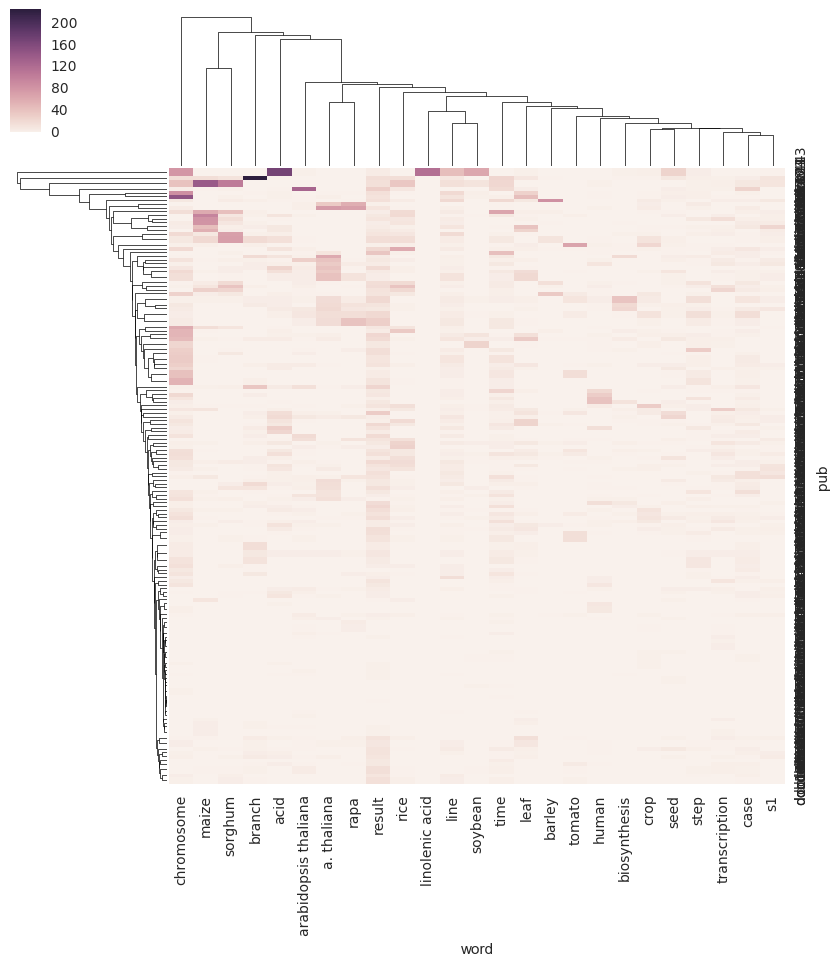

In [24]:
seamap = sns.clustermap(sea2)
#seamap.savefig("output1.png")

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

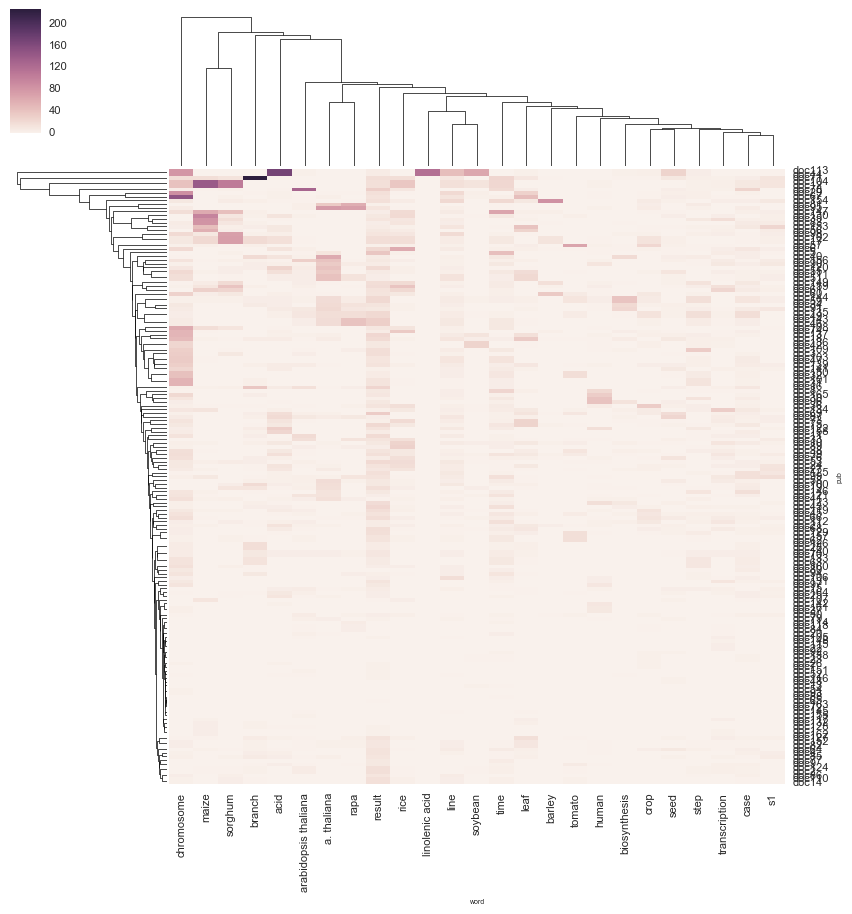

In [25]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})
seamap = sns.clustermap(sea2)
plt.setp(seamap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

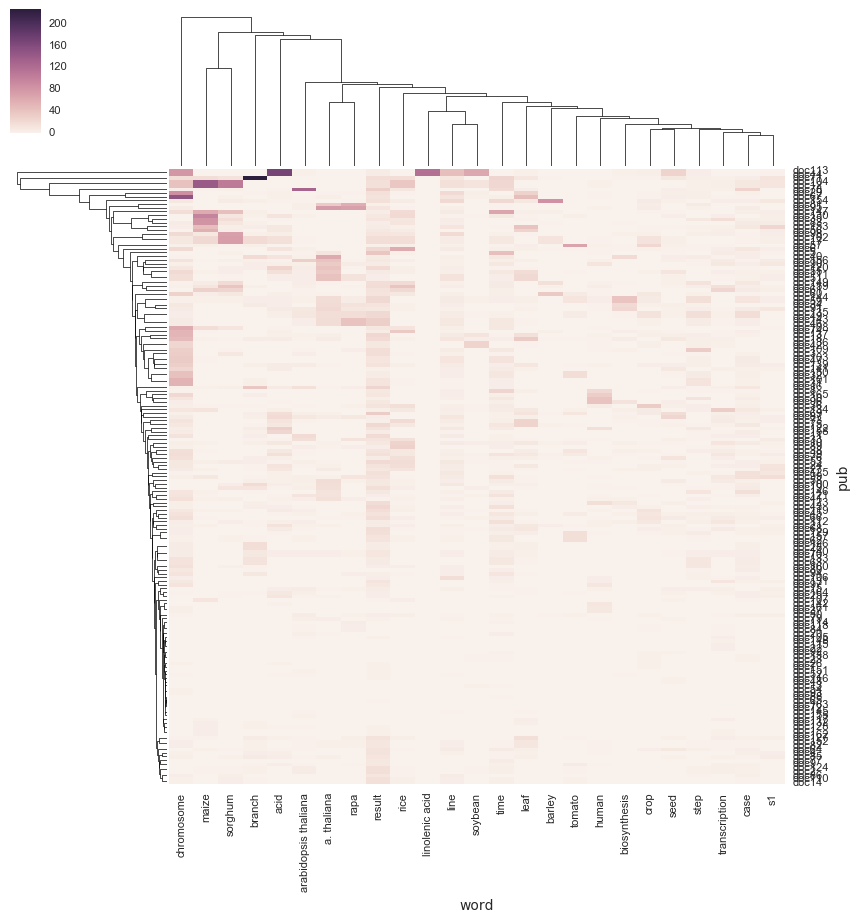

In [26]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":5,"axes.labelsize":10})
seamap = sns.clustermap(sea2)
plt.setp(seamap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

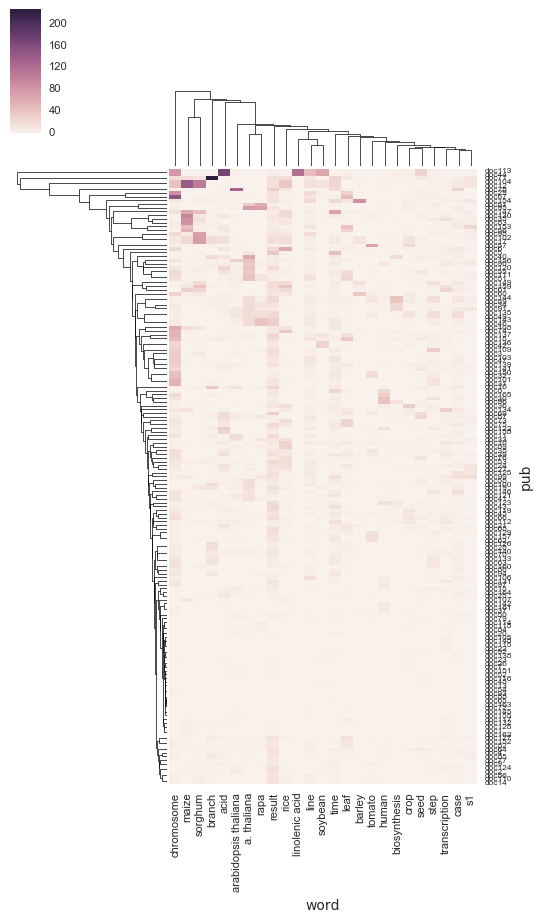

In [54]:
seamap = sns.clustermap(sea2)
hm = seamap.ax_heatmap.get_position()
plt.setp(seamap.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6, rotation=0)
seamap.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*.5, hm.height])
col = seamap.ax_col_dendrogram.get_position()
seamap.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*.5, col.height*.5])

In [28]:
'''Trying to retrieve the seaborn clusters'''
from scipy.spatial import distance
from scipy.cluster import hierarchy
import numpy as np

correlations = sea2.corr()
print(correlations) #25 words x 25 words

word                  a. thaliana      acid  arabidopsis thaliana    barley  \
word                                                                          
a. thaliana              1.000000  0.010578              0.098009 -0.054541   
acid                     0.010578  1.000000             -0.006381 -0.008692   
arabidopsis thaliana     0.098009 -0.006381              1.000000 -0.021347   
barley                  -0.054541 -0.008692             -0.021347  1.000000   
biosynthesis             0.285358  0.042165             -0.009453 -0.031453   
branch                   0.005098 -0.011156             -0.015442  0.014944   
case                     0.140858 -0.064771              0.476753  0.029016   
chromosome              -0.053750  0.371463             -0.047095  0.013977   
crop                     0.046535  0.055454             -0.014995  0.178634   
human                   -0.035207 -0.039698             -0.054965 -0.032768   
leaf                     0.081811  0.049710         

In [58]:
def make_seaborn_data2(x,y,z):
    seaData = []
    
    d = 0
    for document in x:
        i = 0
        for word in y:
            #print(i)
            count = z[i][d] #z[i] = word, z[i][j] = count of word for document
            data = (word, document, count)
            seaData.append(data)

            i += 1    
        d += 1
    return seaData

            

seaData2 = make_seaborn_data2(x,y,z)


seaFrame2 = pd.DataFrame((seaData2), columns=['word', 'publication', 'count'] )
print(seaFrame2)

                      word publication  count
0                  soybean        doc1      0
1                     time        doc1      0
2                   barley        doc1      0
3             biosynthesis        doc1      0
4            transcription        doc1      2
5                    human        doc1      0
6              a. thaliana        doc1      0
7                   branch        doc1      0
8                   tomato        doc1      0
9                    maize        doc1      4
10                    rice        doc1      0
11                    acid        doc1      0
12                    case        doc1      0
13          linolenic acid        doc1      0
14                      s1        doc1      0
15                    line        doc1      0
16                    leaf        doc1      0
17              chromosome        doc1      0
18    arabidopsis thaliana        doc1      0
19                    rapa        doc1      0
20                 sorghum        

In [61]:
sea3 = seaFrame2.pivot("word", "publication", "count")

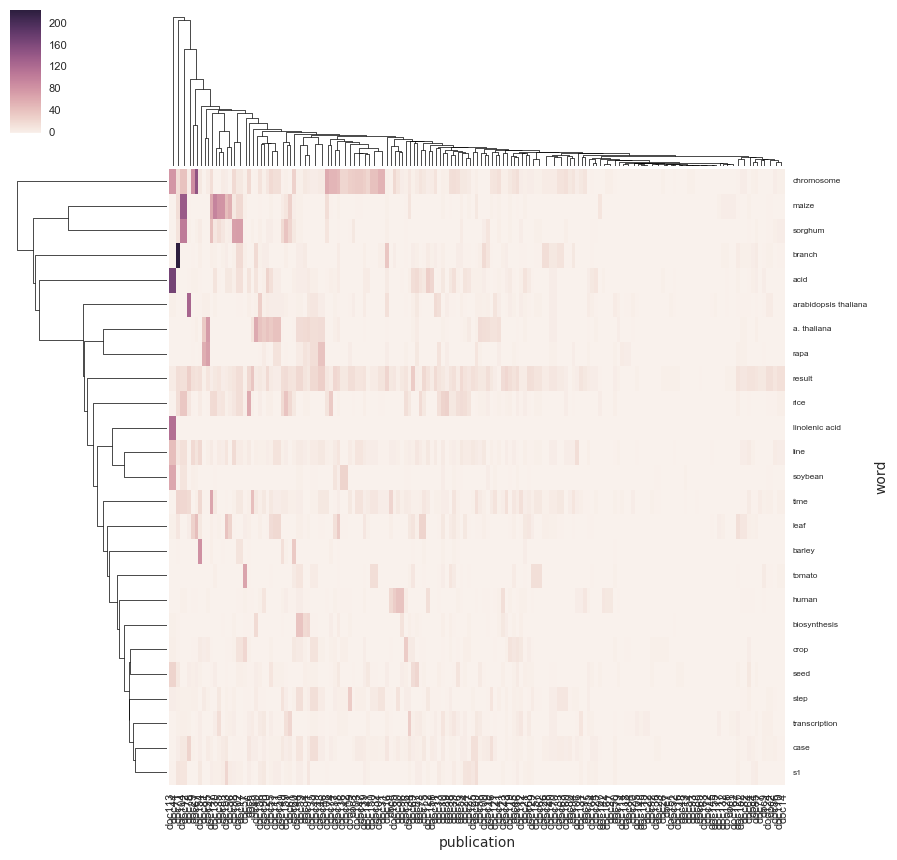

In [76]:
seamap2 = sns.clustermap(sea3)
hm = seamap2.ax_heatmap.get_position()
plt.setp(seamap2.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6, rotation=0)
seamap2.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height])
col = seamap2.ax_col_dendrogram.get_position()
seamap2.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height])

In [29]:
correlations_array = np.asarray(sea2.corr()) #correlations as an array (w/o labels)
print(correlations_array)

[[ 1.       0.01058  0.09801 -0.05454  0.28536  0.0051   0.14086 -0.05375
   0.04654 -0.03521  0.08181  0.05126 -0.04298 -0.0991   0.60947  0.11134
  -0.12311  0.04143  0.03838 -0.07796 -0.06     0.12059 -0.00532 -0.03799
  -0.01964]
 [ 0.01058  1.      -0.00638 -0.00869  0.04216 -0.01116 -0.06477  0.37146
   0.05545 -0.0397   0.04971  0.72301  0.96037 -0.0253  -0.04688  0.0092
  -0.0092   0.03972  0.70945 -0.01454  0.85689  0.02414 -0.07821 -0.02955
  -0.03183]
 [ 0.09801 -0.00638  1.      -0.02135 -0.00945 -0.01544  0.47675 -0.0471
  -0.015   -0.05497 -0.00776 -0.04489 -0.00769 -0.05406  0.05247  0.278
   0.04421 -0.00499  0.10374 -0.03517 -0.02481  0.0143   0.12797 -0.0317
   0.02961]
 [-0.05454 -0.00869 -0.02135  1.      -0.03145  0.01494  0.02902  0.01398
   0.17863 -0.03277  0.03885  0.19876 -0.01708  0.00291 -0.03522  0.09864
   0.1123   0.11649  0.00551  0.1207  -0.0296  -0.02912  0.18171  0.00017
   0.00769]
 [ 0.28536  0.04216 -0.00945 -0.03145  1.       0.03098  0.191   -0.0

In [30]:
row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')
#in the correlations_array rows are words AND columns are words
'''
A 4 by (n-1) matrix Z is returned. 
At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i.
A cluster with an index less than n corresponds to one of the n original observations. 
The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. 
The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.
'''
print(row_linkage)
#print(len(row_linkage)) 24 
crl, coph_distsrl = cophenet(row_linkage, pdist(nesCountX))
print(crl)

[[  1.       12.        0.17001   2.     ]
 [ 20.       25.        0.29347   3.     ]
 [ 13.       19.        0.52042   2.     ]
 [  0.       14.        0.63386   2.     ]
 [ 18.       26.        0.74281   4.     ]
 [ 16.       27.        0.79447   3.     ]
 [ 11.       29.        0.85841   5.     ]
 [  6.       15.        0.88213   2.     ]
 [  8.       23.        0.97034   2.     ]
 [  4.       21.        1.05137   2.     ]
 [ 17.       30.        1.118     4.     ]
 [  2.       32.        1.11838   3.     ]
 [ 22.       35.        1.17226   5.     ]
 [  7.       31.        1.1953    6.     ]
 [ 28.       34.        1.35289   4.     ]
 [ 24.       37.        1.35845   6.     ]
 [  3.       33.        1.40811   3.     ]
 [  5.       10.        1.43839   2.     ]
 [ 36.       39.        1.47088   7.     ]
 [ 40.       42.        1.53361   8.     ]
 [ 41.       43.        1.55516  10.     ]
 [  9.       45.        1.59591  11.     ]
 [ 44.       46.        1.68595  19.     ]
 [ 38.     

In [31]:
col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')
#This is actually the exact same as the row_linkage!
print(col_linkage)
# print(len(col_linkage)) 24

ccl, coph_distscl = cophenet(col_linkage, pdist(nesCountX))
print(ccl)

[[  1.       12.        0.17001   2.     ]
 [ 20.       25.        0.29347   3.     ]
 [ 13.       19.        0.52042   2.     ]
 [  0.       14.        0.63386   2.     ]
 [ 18.       26.        0.74281   4.     ]
 [ 16.       27.        0.79447   3.     ]
 [ 11.       29.        0.85841   5.     ]
 [  6.       15.        0.88213   2.     ]
 [  8.       23.        0.97034   2.     ]
 [  4.       21.        1.05137   2.     ]
 [ 17.       30.        1.118     4.     ]
 [  2.       32.        1.11838   3.     ]
 [ 22.       35.        1.17226   5.     ]
 [  7.       31.        1.1953    6.     ]
 [ 28.       34.        1.35289   4.     ]
 [ 24.       37.        1.35845   6.     ]
 [  3.       33.        1.40811   3.     ]
 [  5.       10.        1.43839   2.     ]
 [ 36.       39.        1.47088   7.     ]
 [ 40.       42.        1.53361   8.     ]
 [ 41.       43.        1.55516  10.     ]
 [  9.       45.        1.59591  11.     ]
 [ 44.       46.        1.68595  19.     ]
 [ 38.     

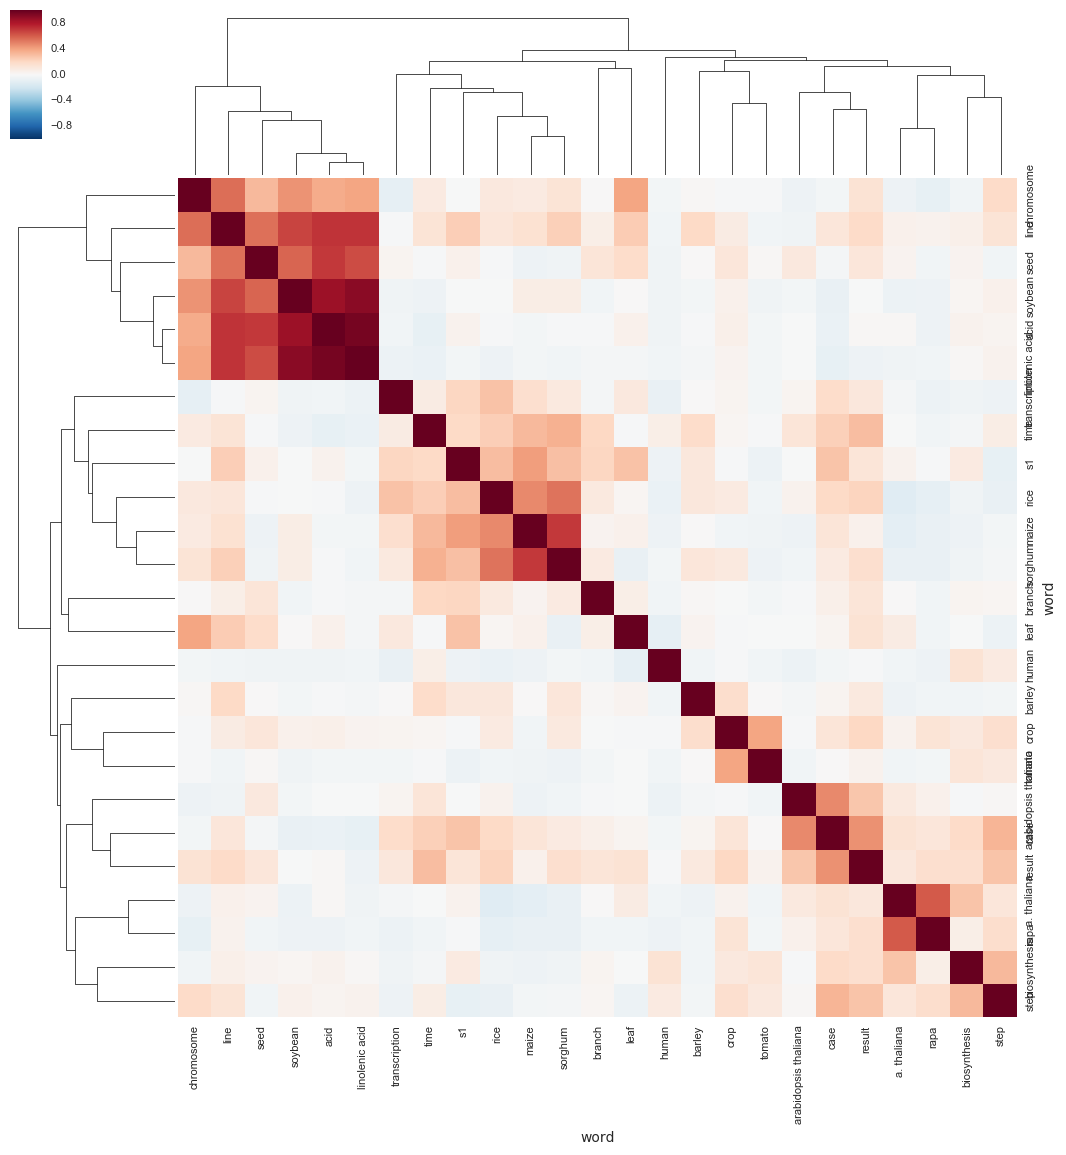

In [32]:
clusters_map = sns.clustermap(correlations, row_linkage=row_linkage, col_linkage=col_linkage, method="average",
               figsize=(13, 13))
#clusters_map.savefig("clustersinclustermap.png")

Index(['doc1', 'doc10', 'doc100', 'doc101', 'doc102', 'doc103', 'doc104',
       'doc105', 'doc106', 'doc107',
       ...
       'doc90', 'doc91', 'doc92', 'doc93', 'doc94', 'doc95', 'doc96', 'doc97',
       'doc98', 'doc99'],
      dtype='object', name='pub', length=165)
RangeIndex(start=0, stop=4125, step=1)
[[15.0, 15.0, 25.0, 25.0], [65.0, 65.0, 75.0, 75.0], [115.0, 115.0, 125.0, 125.0], [105.0, 105.0, 120.0, 120.0], [195.0, 195.0, 205.0, 205.0], [235.0, 235.0, 245.0, 245.0], [225.0, 225.0, 240.0, 240.0], [215.0, 215.0, 232.5, 232.5], [200.0, 200.0, 223.75, 223.75], [185.0, 185.0, 211.875, 211.875], [175.0, 175.0, 198.4375, 198.4375], [165.0, 165.0, 186.71875, 186.71875], [155.0, 155.0, 175.859375, 175.859375], [145.0, 145.0, 165.4296875, 165.4296875], [135.0, 135.0, 155.21484375, 155.21484375], [112.5, 112.5, 145.107421875, 145.107421875], [95.0, 95.0, 128.8037109375, 128.8037109375], [85.0, 85.0, 111.90185546875, 111.90185546875], [70.0, 70.0, 98.450927734375, 98.450927734375], [

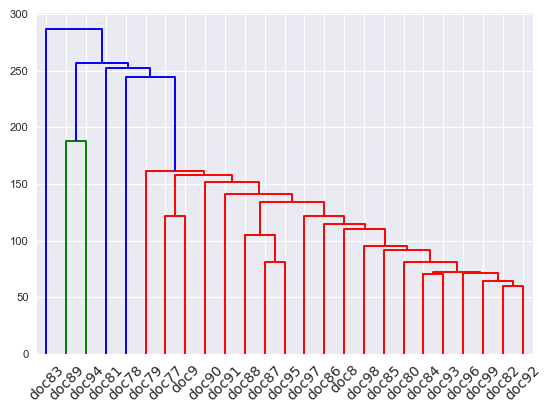

In [33]:
import scipy
print(sea2.index) #list of 165 docs  #sea2 is the inverted of the original seaFrame 
print(seaFrame.index)#RangeIndex(start=0, stop=4125, step=1) <--- doesn't mean anything [[1]]
'''Why choosing dendogram_col and not dendrogram_row???? they are the same,
but i guess dendrogram_col is inverted'''

'''Maybe if I can use the *ROW* and get the INDEX to be the WORDS??'''
den = scipy.cluster.hierarchy.dendrogram(seamap.dendrogram_col.linkage,labels = sea2.index)  
print(den['icoord'])
'''Why are these len=24, and not len=25???'''
print(len(den['icoord']))
print(den['color_list'])
print(len(den['color_list']))

In [34]:
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']): 
        #problem: its zipping but there is not a 1-to-1 match for color and icord. Is this because of 0s? 
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

clusters = get_cluster_classes(den)
# print(list(zip(den['color_list'], den['icoord'])))
# print("--------------------------------------------------")
print(clusters)

{'g': ['doc89', 'doc94'], 'r': ['doc77', 'doc9', 'doc87', 'doc95', 'doc88', 'doc84', 'doc93', 'doc82', 'doc92', 'doc99', 'doc96', 'doc80', 'doc85', 'doc98', 'doc8', 'doc86', 'doc97', 'doc91', 'doc90', 'doc79'], 'b': ['doc78', 'doc81', 'doc83']}


In [35]:
cluster = []
for i in sea2.index:
    included=False
    for j in clusters.keys():
        if i in clusters[j]:
            cluster.append(j)
            included=True
    if not included:
        cluster.append(None)

print(len(cluster))
print(cluster)

165
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'r', 'b', 'r', 'r', 'r', 'b', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'r']
